# ONNX Device Profiling Experiments (Android + Termux/ADB)

This notebook orchestrates the end-to-end experiments:
- Export ONNX from the trained model
- Run host profiling (ONNX)
- Run Android device profiling via ADB using ONNX Runtime perf tool
- Parse, compare, and visualize results

Prerequisites:
- Run this notebook from anywhere; it auto-detects the repo root and switches directories if needed.
- ADB installed and a tablet connected (USB debugging on).
- ONNX Runtime perf binary built for Android arm64 and available under `onnxruntime/build/android-arm64/Release/onnxruntime_perf_test` in this repo.
- Optional: Termux installed on device if you want to run from Termux (not required for ADB flow).

In [1]:
import json, os, re, subprocess, sys, textwrap, shutil
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for candidate in [start, *start.parents]:
        if (candidate / 'pyproject.toml').exists() and (candidate / 'src').exists():
            return candidate
    raise RuntimeError(f'Could not find repo root from {start}')

repo = find_repo_root(Path.cwd())
if Path.cwd().resolve() != repo:
    os.chdir(repo)
    print(f'Switched working directory to {repo}')
else:
    print(f'Running from repo root: {repo}')

exports = repo / 'experiments' / 'exports'
profiles = repo / 'experiments' / 'profiles'
results_dir = repo / 'results'
exports.mkdir(parents=True, exist_ok=True)
profiles.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

def ensure_adb_on_path():
    if shutil.which('adb'):
        print('adb found on PATH')
        return
    candidates = []
    for env_key in ('ANDROID_HOME','ANDROID_SDK_ROOT'):
        root = os.environ.get(env_key)
        if root:
            candidates.append(Path(root)/'platform-tools'/'adb')
    candidates.append(Path.home()/'Library/Android/sdk/platform-tools/adb')
    candidates.append(Path.home()/'Android/Sdk/platform-tools/adb')
    for cand in candidates:
        if cand.exists():
            os.environ['PATH'] = '{}:{}'.format(cand.parent, os.environ['PATH'])
            print(f'Added {cand.parent} to PATH for adb')
            return
    print('Warning: adb not found. Install Android platform-tools or set PATH manually.')
ensure_adb_on_path()
print('Repo path set to:', repo)


Switched working directory to /Users/zhantore/Documents/study/csci447/csci447-final-project
Added /Users/zhantore/Library/Android/sdk/platform-tools to PATH for adb
Repo path set to: /Users/zhantore/Documents/study/csci447/csci447-final-project


## 1) Export ONNX

In [2]:
# Robust ONNX export: try Makefile target if available; fallback to direct module call.
print('Notebook CWD:', Path.cwd())
from pathlib import Path
import subprocess, sys
mf = (repo / 'Makefile')
use_make = mf.exists() and 'export_onnx:' in mf.read_text()
if use_make:
    cmd = ['bash', 'cd']
    cmd = ['bash','-lc','make export_onnx']
    print('Running Make target: make export_onnx')
else:
    cmd = [sys.executable, '-m', 'src.export_onnx', '--config', 'config/default.yaml', '--output-dir', 'experiments']
    print('Running direct module export: python -m src.export_onnx ...')
res = subprocess.run(cmd, cwd=repo, capture_output=True, text=True)
print(res.stdout)
if res.returncode != 0:
    print(res.stderr)
    raise RuntimeError('Export failed')
print('Export completed.')


Notebook CWD: /Users/zhantore/Documents/study/csci447/csci447-final-project
Running Make target: make export_onnx
python -m src.export_onnx --config config/default.yaml --output-dir ./experiments
[11/14/25 14:52:21] INFO     Saved ONNX model to experiments/exports/model.onnx 
                    INFO     ONNX max deviation: 0.000013                       
                    INFO     Export summary saved to                            
                             experiments/exports/summary.json                   

Export completed.


In [3]:
summary_path = exports / 'summary.json'
summary = json.loads(summary_path.read_text())
summary

{'freq': 60,
 'frames': 500,
 'input_dim': 30000,
 'label_map_path': 'experiments/exports/label_map.json',
 'onnx_path': 'experiments/exports/model.onnx',
 'onnx_delta': 1.3232231140136719e-05}

## 2) Host profiling (ONNX)

In [4]:
# Profiles ONNX on the host and writes results into experiments/profiles/{profile.csv, summary.json}.
print('Notebook CWD:', Path.cwd())
cmd = ['bash','-lc','TARGET_DEVICE=android_tablet make profile']
print('Running:', ' '.join(cmd[2:]))
_ = subprocess.run(cmd, cwd=repo, check=False)
host_summary_path = profiles / 'summary.json'
host_results = json.loads(host_summary_path.read_text()) if host_summary_path.exists() else []
host_results

Notebook CWD: /Users/zhantore/Documents/study/csci447/csci447-final-project
Running: TARGET_DEVICE=android_tablet make profile
python -m src.profile_device --config config/default.yaml --output-dir ./experiments --target-device android_tablet
[11/14/25 14:52:25] INFO     Profile saved to experiments/profiles/profile.csv  
[11/14/25 14:52:26] WARNING  Unable to pull Android metrics: Command '['adb',   
                             'shell', 'run-as', 'com.example.fluencyscorer',    
                             'cat', 'files/metrics/latest.json']' returned      
                             non-zero exit status 1.                            


[{'latency_ms': 0.9568666433915496,
  'std_ms': 1.2511123468815386,
  'model': 'onnx',
  'memory_mb': 310.6875,
  'energy_proxy': 1.1482399720698595}]

## 3) Android device profiling via ADB

In [5]:
print('Notebook CWD:', Path.cwd())
# Ensure a device is attached
print(subprocess.run(['bash','-lc','adb devices'], capture_output=True, text=True).stdout)

# Run the robust ADB helper. It auto-detects the perf binary under ./onnxruntime/,
# pushes model + libs, tries -I first, and falls back to a test_data_set_0 if needed.
env = os.environ.copy()
env['ONNX'] = str(exports / 'model.onnx')
env.setdefault('RUNS', '100')
env.setdefault('THREADS', '4')
env.setdefault('EXTRA', '-S 1')  # deterministic random input
cmd = ['bash','-lc','./scripts/adb_benchmark_onnx.sh']
print('Running ADB helper...')
_ = subprocess.run(cmd, cwd=repo, env=env, check=False)
print('ADB profiling finished. Log at', profiles / 'adb_ort_perf.txt')

Notebook CWD: /Users/zhantore/Documents/study/csci447/csci447-final-project
List of devices attached
adb-R52T905ND5T-v3Epcv._adb-tls-connect._tcp	device


Running ADB helper...
[adb] Pushing model and perf binary...


/Users/zhantore/Documents/study/csci447/csci447-final-project/experiments/exports/model.onnx: 1 file pushed, 0 skipped. 17.3 MB/s (15395406 bytes in 0.848s)


[adb] Detected external data file; pushing /Users/zhantore/Documents/study/csci447/csci447-final-project/experiments/exports/model.onnx.data ...


/Users/zhantore/Documents/study/csci447/csci447-final-project/experiments/exports/model.onnx.data: 1 file pushed, 0 skipped. 17.9 MB/s (15425536 bytes in 0.820s)
onnxruntime/build/android-arm64/Release/onnxruntime_perf_test: 1 file pushed, 0 skipped. 64.5 MB/s (30589512 bytes in 0.452s)


[adb] Pushing ONNX Runtime shared libraries from /Users/zhantore/Documents/study/csci447/csci447-final-project/onnxruntime/build/android-arm64/Release...
[adb] Running onnxruntime_perf_test for 100 runs (auto-generated inputs)...


/Users/zhantore/Documents/study/csci447/csci447-final-project/onnxruntime/build/android-arm64/Release/libcustom_op_get_const_input_test_library.so: 1 file pushed, 0 skipped. 106.0 MB/s (350304 bytes in 0.003s)
/Users/zhantore/Documents/study/csci447/csci447-final-project/onnxruntime/build/android-arm64/Release/libcustom_op_invalid_library.so: 1 file pushed, 0 skipped. 20.3 MB/s (5512 bytes in 0.000s)
/Users/zhantore/Documents/study/csci447/csci447-final-project/onnxruntime/build/android-arm64/Release/libcustom_op_library.so: 1 file pushed, 0 skipped. 194.4 MB/s (554600 bytes in 0.003s)
/Users/zhantore/Documents/study/csci447/csci447-final-project/onnxruntime/build/android-arm64/Release/libcustom_op_local_function.so: 1 file pushed, 0 skipped. 171.5 MB/s (359384 bytes in 0.002s)
4 files pushed, 0 skipped. 17.0 MB/s (1269800 bytes in 0.071s)


Setting intra_op_num_threads to 4
Session creation time cost: 0.201008 s
First inference time cost: 2 ms
Total inference time cost: 0.405707 s
Total inference requests: 100
Average inference time cost total: 4.057070 ms
Total inference run time: 0.405994 s
Number of inferences per second: 246.309 
Avg CPU usage: 46 %
Peak working set size: 53682176 bytes
Avg CPU usage:46
Peak working set size:53682176
Runs:100
Min Latency: 0.001565 s
Max Latency: 0.123581 s
P50 Latency: 0.00165755 s
P90 Latency: 0.00207938 s
P95 Latency: 0.00852635 s
P99 Latency: 0.123581 s
P999 Latency: 0.123581 s
\nSaved raw output to experiments/profiles/adb_ort_perf.txt
avg_ms: ms
p50_s: 0.00165755
p90_s: 0.00207938
p95_s: 0.00852635
p99_s: 0.123581
ADB profiling finished. Log at /Users/zhantore/Documents/study/csci447/csci447-final-project/experiments/profiles/adb_ort_perf.txt


In [6]:
# Parse adb_ort_perf.txt for latency stats
log_path = profiles / 'adb_ort_perf.txt'
adb_text = log_path.read_text() if log_path.exists() else ''
def parse_perf(text: str):
    out = {}
    m = re.search(r'Average inference time cost total:\s*([\d.]+)\s*ms', text)
    if m: out['avg_ms'] = float(m.group(1))
    for k in ['P50','P90','P95','P99']:
        m = re.search(rf'{k}\s+Latency:\s*([\d.]+)\s*s', text)
        if m: out[k.lower()+'_ms'] = float(m.group(1))*1000.0
    return out
adb_metrics = parse_perf(adb_text)
adb_metrics

{'avg_ms': 4.05707,
 'p50_ms': 1.65755,
 'p90_ms': 2.07938,
 'p95_ms': 8.52635,
 'p99_ms': 123.581}

## 4) Compare and visualize

In [7]:
rows = []
for item in host_results if isinstance(host_results, list) else []:
    if 'latency_ms' in item:
        rows.append({'where':'host', 'model': item.get('model','onnx'), 'avg_ms': item['latency_ms'], 'std_ms': item.get('std_ms', np.nan)})
if adb_metrics:
    rows.append({'where':'android', 'model':'onnx', 'avg_ms': adb_metrics.get('avg_ms', np.nan), 'std_ms': np.nan})
df = pd.DataFrame(rows)
df

,where,model,avg_ms,std_ms
0,host,onnx,0.956867,1.251112
1,android,onnx,4.057070,NaN


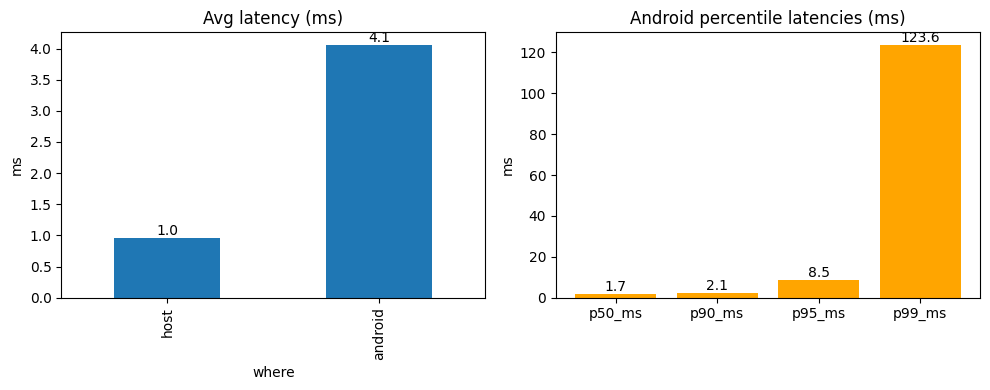

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
if not df.empty:
    df.plot(x='where', y='avg_ms', kind='bar', legend=False, title='Avg latency (ms)', ax=axes[0])
    axes[0].set_ylabel('ms')
    for p in axes[0].patches:
        axes[0].annotate(f"{p.get_height():.1f}", (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='bottom')
    metrics = ['p50_ms','p90_ms','p95_ms','p99_ms']
    android_metrics = {k: adb_metrics.get(k) for k in metrics} if adb_metrics else {}
    android_series = {k: v for k,v in android_metrics.items() if v is not None}
    if android_series:
        axes[1].bar(android_series.keys(), android_series.values(), color='orange')
        axes[1].set_title('Android percentile latencies (ms)')
        axes[1].set_ylabel('ms')
        for idx_bar, val in enumerate(android_series.values()):
            axes[1].annotate(f"{val:.1f}", (idx_bar, val), ha='center', va='bottom')
    else:
        axes[1].set_visible(False)
else:
    print('No data to plot.')
plt.tight_layout()
plt.show()


In [9]:
# Save combined summary
combined = {
    'export_summary': summary,
    'host_profile': host_results,
    'android_profile': adb_metrics,
}
out_path = results_dir / 'jupyter_profile_summary.json'
out_path.write_text(json.dumps(combined, indent=2))
out_path

PosixPath('/Users/zhantore/Documents/study/csci447/csci447-final-project/results/jupyter_profile_summary.json')